In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import time
import scipy
import sklearn
import copy
import importlib


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
# Read Hao dataset
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [4]:
adata.var.head()

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3


In [5]:
# Read gene symbol to ensembl id mapping
gene_mapping = pd.read_csv('mygene_result_v3.csv', index_col=0)
gene_mapping.head()

,_id,_score,name,symbol,ensembl.gene,entrezgene,notfound,ensembl
query,,,,,,,,
MIR1302-2HG,ENSG00000243485,26.271759,MIR1302-2 host gene,MIR1302-2HG,ENSG00000243485,NaN,False,NaN
FAM138A,645520,27.063152,family with sequence similarity 138 member A,FAM138A,ENSG00000237613,645520.0,False,NaN
OR4F5,79501,25.752413,olfactory receptor family 4 subfamily F member 5,OR4F5,ENSG00000186092,79501.0,False,NaN
AL627309.1,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
AL627309.3,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [6]:
adata.var['ensembl'] = gene_mapping['ensembl.gene']
adata.var['id'] = gene_mapping['_id']
adata.var['name'] = gene_mapping['name']
adata.var.head()

,ensembl,id,name
MIR1302-2HG,ENSG00000243485,ENSG00000243485,MIR1302-2 host gene
FAM138A,ENSG00000237613,645520,family with sequence similarity 138 member A
OR4F5,ENSG00000186092,79501,olfactory receptor family 4 subfamily F member 5
AL627309.1,NaN,NaN,NaN
AL627309.3,NaN,NaN,NaN


In [7]:
success_mapped = gene_mapping[gene_mapping['ensembl.gene'].notna()]
success_mapped.shape

(23192, 8)

## Read PreLect features

In [8]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [9]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,11,6
CD4_T,346,197
CD8_T,22,7
DC,32,15
Mono,19,10
NK,33,17
other,4,2
other_T,59,25


In [10]:
# check if PreLect features can be mapped to ensembl
len(set(features_dict['B']['Gene'].tolist()) & set(success_mapped.index.tolist()))

11

In [11]:
for celltype in features_dict.keys():
    print(celltype)
    print(len(set(features_dict[celltype]['Gene'].tolist()) & set(success_mapped.index.tolist())))

B
11
CD4_T
337
CD8_T
20
DC
29
Mono
18
NK
29
other
4
other_T
58


## Zheng

In [12]:
# Read Zheng query dataset
query_adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
query_adata.shape

(68579, 32738)

In [13]:
query_adata.var.head()

,gene_symbols
ENSG00000243485,MIR1302-10
ENSG00000237613,FAM138A
ENSG00000186092,OR4F5
ENSG00000238009,RP11-34P13.7
ENSG00000239945,RP11-34P13.8


In [30]:
# Intersection of Hao ensembl and Zheng ensembl
len(set(success_mapped['ensembl.gene'].tolist()) & set(query_adata.var_names.tolist()))

20208

## Subset to the same set of PreLect features for Zheng prediction
### 1. with Ensembl

In [15]:
success_mapped.head()

,_id,_score,name,symbol,ensembl.gene,entrezgene,notfound,ensembl
query,,,,,,,,
MIR1302-2HG,ENSG00000243485,26.271759,MIR1302-2 host gene,MIR1302-2HG,ENSG00000243485,NaN,False,NaN
FAM138A,645520,27.063152,family with sequence similarity 138 member A,FAM138A,ENSG00000237613,645520.0,False,NaN
OR4F5,79501,25.752413,olfactory receptor family 4 subfamily F member 5,OR4F5,ENSG00000186092,79501.0,False,NaN
OR4F29,729759,25.746635,olfactory receptor family 4 subfamily F member 29,OR4F29,ENSG00000284733,729759.0,False,NaN
OR4F16,81399,26.272050,olfactory receptor family 4 subfamily F member 16,OR4F16,ENSG00000284662,81399.0,False,NaN


In [17]:
celltype = 'B'
features = features_dict[celltype]['Gene'].tolist()
features = [success_mapped.at[f, 'ensembl.gene'] for f in features if f in success_mapped.index]
features

['ENSG00000196154',
 'ENSG00000211592',
 'ENSG00000019582',
 'ENSG00000206308',
 'ENSG00000196604',
 'ENSG00000205542',
 'ENSG00000156738',
 'ENSG00000251562',
 'ENSG00000282657',
 'ENSG00000273686',
 'ENSG00000105369']

In [23]:
len(set(features) & set(query_adata.var_names.tolist()))

7

In [90]:
for celltype in types:
    features = features_dict[celltype]['Gene'].tolist()  # feature in gene symbol
    features = [success_mapped.at[f, 'ensembl.gene'] for f in features if f in success_mapped.index]  # feature in ensembl
    print(celltype, len(set(features) & set(query_adata.var_names.tolist())))

B 7
CD4_T 312
CD8_T 16
DC 21
Mono 13
NK 27
other 3
other_T 50


### 2. with gene symbol

In [47]:
# change Zheng query dataset var index from ensemble to gene symbol
query_adata_sym = copy.deepcopy(query_adata)
query_adata_sym.var['ensembl'] = query_adata_sym.var.index.tolist()
query_adata_sym.var.index = query_adata_sym.var['gene_symbols'].tolist()
query_adata_sym.var_names_make_unique()
query_adata_sym.var.head()

,gene_symbols,ensembl
MIR1302-10,MIR1302-10,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
RP11-34P13.7,RP11-34P13.7,ENSG00000238009
RP11-34P13.8,RP11-34P13.8,ENSG00000239945


In [31]:
# read LR classifier from pkl
celltype = 'B'
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/LR_classifiers')
with open(f'LR_{celltype}_Harmony_l1.pkl', 'rb') as f:
    lr = pickle.load(f)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [67]:
# PreLect features (symbol)
train_genes = features_dict[celltype]['Gene'].tolist()

# PreLect features (symbol) have 9 intersectoin with Zheng (symbol)
query_genes = query_adata_sym.var_names.tolist()
common_genes = list(set(train_genes) & set(query_genes))

# Create a full matrix for query data, initializing with zeros for missing genes
X_query_full = np.zeros((query_adata_sym.shape[0], len(train_genes)))
# Fill in the values for the common genes
for i, gene in enumerate(train_genes):
    if gene in common_genes:
        X_query_full[:, i] = query_adata_sym[:, gene].X.toarray().flatten()

# X_query = query_adata_sym[:, common_genes].X
print(X_query_full.shape)
type(X_query_full)

(68579, 11)


numpy.ndarray

In [77]:
# predict on query dataset
y_query_pred = lr.predict(X_query_full)
sum(y_query_pred == 1)  # predict celltype 的有幾個

610

In [75]:
# Get the probability of individual cell predicting as the positive class
y_query_prob = lr.predict_proba(X_query_full)[:, 1]  # Probability for the positive class (class 1)
sum(y_query_prob > 0.5)  # >0.5: predict celltype, <0.5: predict not celltype

610

In [134]:
def predict_celltype_w_symbol(LR_model, query_adata, features_dict, celltype):
    # PreLect features (symbol)
    train_genes = features_dict[celltype]['Gene'].tolist()

    # PreLect features (symbol) have 9 intersectoin with Zheng (symbol)
    query_genes = query_adata.var_names.tolist()
    common_genes = list(set(train_genes) & set(query_genes))
    print('No. common genes:', len(common_genes))

    # Create a full matrix for query data, initializing with zeros for missing genes
    X_query_full = np.zeros((query_adata.shape[0], len(train_genes)))
    # Fill in the values for the common genes
    for i, gene in enumerate(train_genes):
        if gene in common_genes:
            X_query_full[:, i] = query_adata[:, gene].X.toarray().flatten()

    # predict on query dataset
    y_query_pred = LR_model.predict(X_query_full)
    print('Prediction = 1:', sum(y_query_pred == 1))  # predict celltype 的有幾個

    # Get the probability of individual cell predicting as the positive class
    y_query_prob = LR_model.predict_proba(X_query_full)[:, 1]  # Probability for the positive class (class 1)
    print('Probability > 0.5:', sum(y_query_prob > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return y_query_pred, y_query_prob

In [ ]:
celltype = 'B'
with open(f'LR_{celltype}_Harmony_l1.pkl', 'rb') as f:
    lr_B = pickle.load(f)

B_y_pred, B_y_prob = predict_celltype_w_symbol(lr_B, query_adata_sym, features_dict, celltype)

In [88]:
# predict all celltypes, get prediction and likelihood
prediction_dict = {}
likelihood_dict = {}

for celltype in types:
    print(celltype)
    with open(f'LR_{celltype}_Harmony_l1.pkl', 'rb') as f:
        lr_celltype = pickle.load(f)
    y_pred_celltype, y_prob_celltype = predict_celltype_w_symbol(lr_celltype, query_adata_sym, features_dict, celltype)
    prediction_dict[celltype] = y_pred_celltype
    likelihood_dict[celltype] = y_prob_celltype

B
No. common genes: 9


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 610
Probability > 0.5: 610
CD4_T
No. common genes: 334


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 65913
Probability > 0.5: 65913
CD8_T
No. common genes: 21


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 32692
Probability > 0.5: 32692
DC
No. common genes: 32


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 3100
Probability > 0.5: 3100
Mono
No. common genes: 19


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 2027
Probability > 0.5: 2027
NK
No. common genes: 33


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 636
Probability > 0.5: 636
other
No. common genes: 4
Prediction = 1: 402
Probability > 0.5: 402
other_T
No. common genes: 53


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prediction = 1: 418
Probability > 0.5: 418


In [93]:
query_adata_sym.obs['celltype'].value_counts()

celltype
CD8+ Cytotoxic T                20773
CD8+/CD45RA+ Naive Cytotoxic    16666
CD56+ NK                         8776
CD4+/CD25 T Reg                  6187
CD19+ B                          5908
CD4+/CD45RO+ Memory              3061
CD14+ Monocyte                   2862
Dendritic                        2099
CD4+/CD45RA+/CD25- Naive T       1873
CD34+                             277
CD4+ T Helper2                     97
Name: count, dtype: int64

In [95]:
prediction_df = pd.DataFrame(prediction_dict)
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,1.055932e-19,1.000000,0.953148,1.025038e-19,2.451483e-10,1.093836e-13,3.695499e-21,5.979191e-05
1,1.922833e-33,1.000000,0.998860,7.930622e-30,1.382571e-11,9.610319e-22,4.044491e-31,4.990756e-10
2,3.740313e-36,1.000000,0.000458,7.263677e-36,9.646819e-13,5.428266e-32,9.730696e-29,7.113715e-19
3,9.993695e-01,0.987046,0.003460,1.613094e-02,1.152227e-08,3.923444e-09,1.492544e-11,1.347849e-05
4,7.041269e-28,1.000000,0.981771,1.183579e-17,9.322300e-08,6.164184e-12,1.038114e-16,1.487848e-04


## Plot likelihood on UMAP

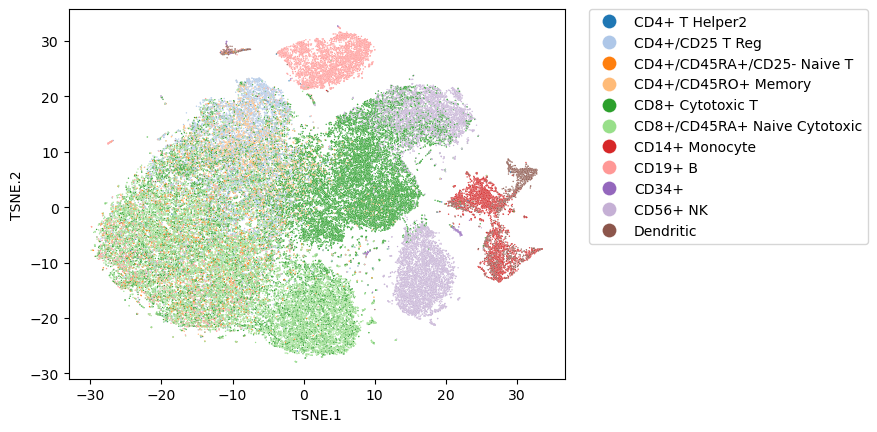

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

obs = query_adata_sym.obs
# Create the scatter plot
ax = sns.scatterplot(x='TSNE.1', y='TSNE.2', hue='celltype', data=obs, s=1, legend="full", palette='tab20')

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)
# plt.legend(handles, labels)

plt.show()

In [123]:
# Concatenate the likelihood_df with the adata.obs
likelihood_df.index = query_adata_sym.obs_names
query_adata_sym.obs = pd.concat([query_adata_sym.obs, likelihood_df], axis=1)
query_adata_sym.obs.head()

,celltype,TSNE.1,TSNE.2,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,1.055932e-19,1.000000,0.953148,1.025038e-19,2.451483e-10,1.093836e-13,3.695499e-21,5.979191e-05
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,1.922833e-33,1.000000,0.998860,7.930622e-30,1.382571e-11,9.610319e-22,4.044491e-31,4.990756e-10
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,3.740313e-36,1.000000,0.000458,7.263677e-36,9.646819e-13,5.428266e-32,9.730696e-29,7.113715e-19
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,9.993695e-01,0.987046,0.003460,1.613094e-02,1.152227e-08,3.923444e-09,1.492544e-11,1.347849e-05
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,7.041269e-28,1.000000,0.981771,1.183579e-17,9.322300e-08,6.164184e-12,1.038114e-16,1.487848e-04


(68579, 32738)
(68579, 2000)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


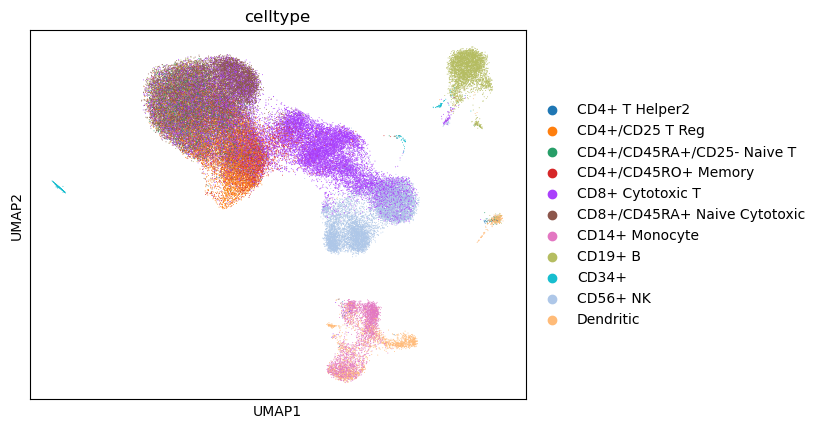

In [125]:
# Get UMAP embedding
query_adata_sym_copy = copy.deepcopy(query_adata_sym)
print(query_adata_sym_copy.shape)

# Normalization
sc.pp.normalize_total(query_adata_sym_copy, target_sum=None)
sc.pp.log1p(query_adata_sym_copy)

# HVG2000
sc.pp.highly_variable_genes(query_adata_sym_copy, n_top_genes=2000)
# filtering HVG2000
query_adata_sym_copy = query_adata_sym_copy[:, query_adata_sym_copy.var.highly_variable]
print(query_adata_sym_copy.shape)

# PCA
sc.tl.pca(query_adata_sym_copy, svd_solver='arpack')

# Neighboring graph
sc.pp.neighbors(query_adata_sym_copy, n_neighbors=10, n_pcs=50)
sc.tl.umap(query_adata_sym_copy)
sc.pl.umap(query_adata_sym_copy, color='celltype')

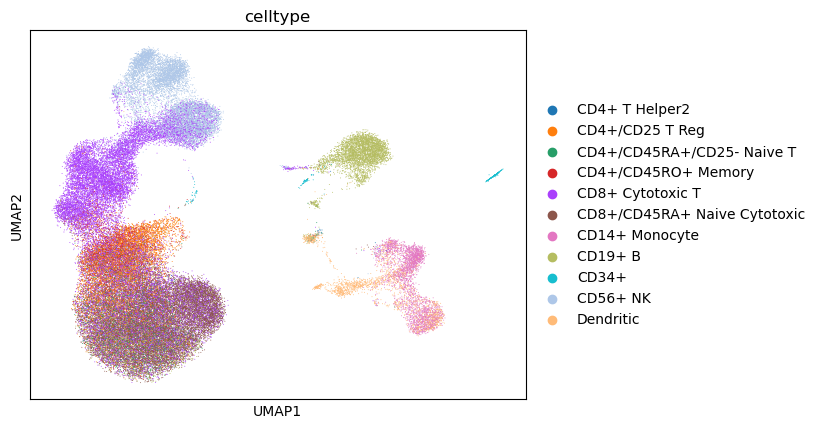

In [127]:
# Leiden and PAGA
sc.tl.leiden(query_adata_sym_copy, resolution=0.9)
sc.tl.paga(query_adata_sym_copy)
sc.pl.paga(query_adata_sym_copy, plot=False)
sc.tl.umap(query_adata_sym_copy, init_pos='paga')
sc.pl.umap(query_adata_sym_copy, color='celltype')

In [129]:
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

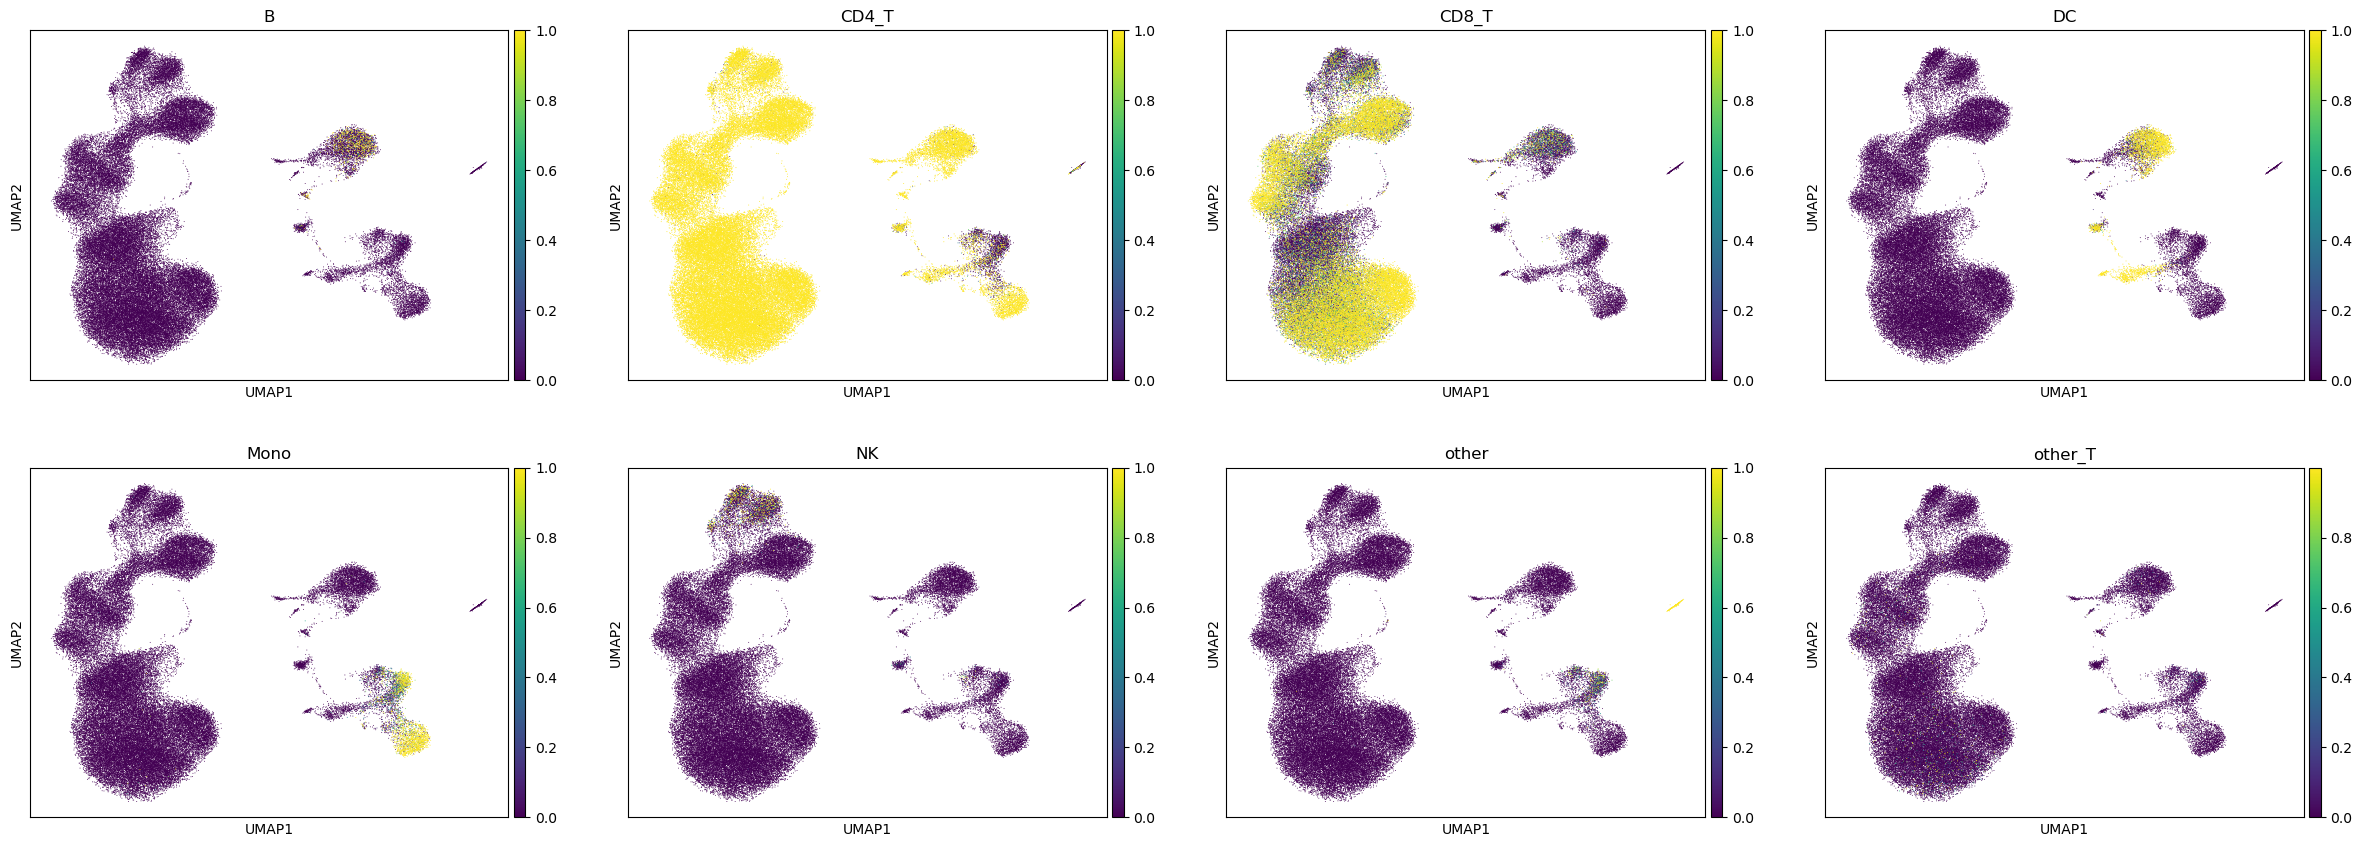

In [130]:
sc.pl.umap(query_adata_sym_copy, color=types)